Generate instance, solve, draw BER.
Generate fixed point instance for FPGA test

# Create Path for files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import commpy as comm
import cmath
import numpy as np
import math
from scipy.sparse import coo_matrix
import os

# common_path = 'G:/Cornell/QuAIL/codes/CIMSimulator/instances/MIMO_decoding/di_mimo/'
common_path = './tb_data/'

path_to_all_instances = common_path + 'instances/'
path_to_all_solutions = common_path + 'ideal_solutions/'
path_to_all_solved    = common_path + 'solved_solutions/'

path_to_all_HLS_tb    = common_path + 'HLS_tb_data/' # for HLS tb
path_to_all_HLS_solved    = common_path + 'HLS_solved_solutions/'
#TODO: path_to_all_HLS_tb is not consistent with the HLS code tb yet

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_instances)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_instances)
    print("Created new directory for problem instances")
else:
    print("Directory for problem instances already exists")
print("Directory for problem instances: ", path_to_all_instances)

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_solutions)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_solutions)
    print("Created new directory for solutions")
else:
    print("Directory for solutions already exists")
print("Directory for solutions: ", path_to_all_solutions)

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_solved)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_solved)
    print("Created new directory for solutions")
else:
    print("Directory for solutions already exists")
print("Directory for solutions: ", path_to_all_solved)

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_HLS_solved)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_HLS_solved)
    print("Created new directory for HLS solutions")
else:
    print("Directory for HLS solutions already exists")
print("Directory for HLS solutions: ", path_to_all_HLS_solved)

# Check whether the specified path exists or not
isExist = os.path.exists(path_to_all_HLS_tb)
if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path_to_all_HLS_tb)
    print("Created new directory for solutions")
else:
    print("Directory for solutions already exists")
print("Directory for solutions: ", path_to_all_HLS_tb)


Created new directory for problem instances
Directory for problem instances:  ./tb_data/instances/
Created new directory for solutions
Directory for solutions:  ./tb_data/ideal_solutions/
Created new directory for solutions
Directory for solutions:  ./tb_data/solved_solutions/
Created new directory for HLS solutions
Directory for HLS solutions:  ./tb_data/HLS_solved_solutions/
Created new directory for solutions
Directory for solutions:  ./tb_data/HLS_tb_data/


## Create Instances

In [24]:
#N_t x N_r MIMO

N_t = 16                #Number Of Transmit antennas
N_r = 16                #Number of Receive antennas
modulation = 16         #Type of modulation
numInstances = 100       #Number of Ising Instances to generate

bits_per_symbol = int(math.log2(modulation))

bitsPerEntry = int(0.5*bits_per_symbol)

maxQI = 2*np.sqrt(modulation/4) - 1

_qam = comm.QAMModem(modulation)

totalBits = bits_per_symbol*N_t

snr_list = [0, 5, 10, 15, 20, 25, 30] ## in dB
print("snr_list: ", snr_list)

instance_type = "Nt"+str(N_t)+"_Nr"+str(N_r)+"_"+str(modulation)+"QAM/"
print("instance_type: ", instance_type)


snr_list:  [0, 5, 10, 15, 20, 25, 30]
instance_type:  Nt16_Nr16_16QAM/


In [25]:
H = np.zeros((N_r,N_t),dtype=np.complex128)

# ## Seed for verification
# np.random.seed(1)

for snr in snr_list:
  path_to_instances = path_to_all_instances + instance_type + str(snr) + "/"
  path_to_solutions = path_to_all_solutions + instance_type + str(snr) + "/"

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_instances)

  if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path_to_instances)
      print("Created new directory for problem instances for snr ", snr, " in", path_to_instances)
  else:
      print("Directory for problem instances for snr ", snr, " already exists in", path_to_instances)

  # Check whether the specified path exists or not
  isExist = os.path.exists(path_to_solutions)

  if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path_to_solutions)
      print("Created new directory for ideal solutions for snr ", snr)
  else:
      print("Directory for ideal solutions for snr ", snr, " already exists")

  ## Generate random channel matrices (complex)
  for k in range(numInstances):
    H = (1/np.sqrt(2))*(np.random.randn(N_r, N_t) + 1j*np.random.randn(N_r, N_t))

    ## Generate random transmissions
    x = np.zeros((N_t),dtype=np.complex128)

    for i in range(N_t):
      x[i] = _qam.modulate(comm.utilities.dec2bitarray(np.random.randint(0,modulation-1),bits_per_symbol))

    y = np.zeros((N_r),dtype=np.complex128)

    ## Find the corresponding received vectors
    y_rec = np.matmul(H,x)

    ## Add noise
    ey2 = np.mean(np.abs(y)**2)
    
    # var = ey2/(10**(snr/10)) 
    var = ey2*(10**(-1*snr/10))
    
    y += np.sqrt(0.5) * (np.random.normal(scale=np.sqrt(var), size=(N_r)) + 1j*np.random.normal(scale=np.sqrt(var), size=(N_r)))

    temp = np.conjugate(H.T)@H
    # noise_correction = (1/(10**(snr/10))) * np.identity(np.shape(H)[1])
    noise_correction = (10**(-1*snr/10)) * np.identity(np.shape(H)[1])
    
    D = np.linalg.inv(temp + noise_correction)@(np.conjugate(H.T))

    x_mmse = _qam.modulate(_qam.demodulate(D@y_rec, "hard"))

    ## J is the internal field matrix for the Ising problem
    J = np.zeros((4*N_t,4*N_t))
    ## h is the external field. We can get rid of this by adding an 
    ## auxiliary spin (shown in paper)
    h = np.zeros((4*N_t))

    y = y_rec - H@x_mmse

    ## Transformation from complex matrices to real-valued matrices
    ## (refer to paper for more details)
    t1 = np.concatenate((H.real,-1*H.imag),axis=1)
    t2 = np.concatenate((H.imag, H.real),axis=1)

    H_r = np.concatenate((t1,t2),axis=0)
    y_r = np.concatenate((y.real,y.imag),axis=0)

    j_temp = H_r.T @ H_r
    J1 = np.hstack((j_temp, j_temp))
    J1 = -np.vstack((J1, J1))

    h_temp = 2*(y_r.T@H_r)
    h1 = np.concatenate((h_temp, h_temp), axis=0)

    np.fill_diagonal(J1, 0)

    max_J = np.absolute(J1).max()
    max_h = np.absolute(h1).max()

    ## Scale to keep all entries between -1 and 1
    scale = max(max_J,max_h)
    J = J1/scale
    h = h1/(2*scale)

    ## Save the expected solution
    with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "w") as file:
      #file.write("##\t"  + str(len(x)) + "\n")
      np.savetxt(file, x)

    with open(path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt", "w") as file:
      #file.write("##\t"  + str(len(x)) + "\n")
      np.savetxt(file, x_mmse)
    
    # Recast as pure quadratic and save for running in HLS
    h_reshaped = np.reshape(h, (1, 4*N_t))
    J_temp = np.vstack((J, h_reshaped))

    h_temp = h_reshaped.T
    h_temp = np.reshape(np.append(h_temp, 0), (4*N_t + 1, 1))
    J_quad = np.hstack((J_temp, h_temp))

    with open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "w") as file:
      np.savetxt(file, J_quad)


Directory for problem instances for snr  0  already exists in ./tb_data/instances/Nt16_Nr16_16QAM/0/
Directory for ideal solutions for snr  0  already exists
Directory for problem instances for snr  5  already exists in ./tb_data/instances/Nt16_Nr16_16QAM/5/
Directory for ideal solutions for snr  5  already exists
Directory for problem instances for snr  10  already exists in ./tb_data/instances/Nt16_Nr16_16QAM/10/
Directory for ideal solutions for snr  10  already exists
Directory for problem instances for snr  15  already exists in ./tb_data/instances/Nt16_Nr16_16QAM/15/
Directory for ideal solutions for snr  15  already exists
Directory for problem instances for snr  20  already exists in ./tb_data/instances/Nt16_Nr16_16QAM/20/
Directory for ideal solutions for snr  20  already exists
Directory for problem instances for snr  25  already exists in ./tb_data/instances/Nt16_Nr16_16QAM/25/
Directory for ideal solutions for snr  25  already exists
Directory for problem instances for snr 

# Solver (matrix formulation)

*parameters used on simulation below*
```python
CIM_AHC_tf(
    total_time=2.56, J, time_step=0.01, 
    r=0.98, mu = 1, beta=1, target_a_baseline=0, 
    num_anneals=64, coupling_str=100, 
    use_sign=1, gamma=1/2.56, modulate_parameter="target_a",
    add_noise=1, use_last = 0
)
```

In [26]:
def CIM_AHC_tf(T_time, J, time_step, r=0.2, beta=0.05, coupling_str=0.07, mu=1, noise=0, ground_energy=0, num_anneals = 1, target_a_baseline = 0.2, use_sign=0, gamma = 0.02, modulate_parameter="target_a", add_noise = 0, use_last = 0):

    N = J.shape[1]
    
    ticks = int(T_time/time_step) #actual number of steps
    plot_data = np.zeros((N, num_anneals, ticks))

    #r = Linear Gain
    #beta = Error Variable Rate of Change
    #coupling_str = Coupling Strength (F_J coefficient)
    target_a = target_a_baseline

    ## Turns out that the initilization makes a biiig difference!
    #x = 0.001 * np.random.rand(N, num_anneals) - 0.0005
    #error_var = np.abs(0.001 * np.random.rand(N, num_anneals) - 0.0005)

    # for debug, load preset x and error_var
    # x = np.sqrt(0.001) * np.random.normal(0,1,(N, num_anneals))
    # error_var = np.abs(np.sqrt(0.001)* np.random.normal(0,1,(N, num_anneals)))
    
    # load preset x and error_var from x_file.txt and error_var_file.txt (use the first row)
    x = (np.loadtxt('x_file.txt')[:,:]).reshape(N, num_anneals)
    error_var = (np.loadtxt('error_var_file.txt')[:,:]).reshape(N, num_anneals)
    # print("x.shape = ", x.shape)
    # print("error_var.shape = ", error_var.shape)
    
    
    etc_flag = np.ones((N, num_anneals))

    energies = np.zeros((num_anneals, ticks))

    for t in range(ticks):
        # print("\nTime Step ", t)
        # print("x = ", x)
        # print("e = ", error_var)

        if t > 1:
            prev_signs = np.sign(plot_data[:,:, t-1])
            compare_signs = prev_signs != np.sign(x)
            comparison = compare_signs.any()
            if comparison:
                etc_flag = error_var
            else:
                etc_flag = etc_flag #np.ones(N)

        if use_sign:
            MVM = (J).dot(np.sign(x))
        else:    
            MVM = (J).dot(x)
        # print("MVM = ", MVM)

        #Evolve Spin Variables
        xx = x**2
        x += (x*((r-1) - mu*xx)) * time_step
        x += coupling_str*(MVM*error_var) * time_step

        if add_noise == 1:
            x += np.sqrt(0.0005) * np.random.normal(0,1,(N, num_anneals))

        plot_data[:,:,t] = x 

        #Evolve Error Variables
        # xx = x**2
        error_var += -(beta*((xx) - target_a)*error_var) * time_step

        sig = np.sign(x)

        if modulate_parameter=="target_a":
            #Modulate Target Amplitude
            # delta_a = coupling_str*np.mean((J.dot(sig))*sig*etc_flag)
            delta_a = gamma*time_step
            target_a  = target_a_baseline + delta_a

        elif modulate_parameter=="coupling_str":
            coupling_str += time_step * gamma

        # plot_data[:,t] = x
        curr_ising_energy = np.diag(-1/2*(sig.T@J@sig))
        energies[:, t] = curr_ising_energy

    if use_last == 1:
        sol_time = -1
        best_anneal = np.argmin(energies[:,sol_time])

    else: 
        best_anneal = np.argmin(energies)//ticks
        sol_time = np.argmin(energies)%ticks

    best_energies = energies[best_anneal, :]
    best_plot_data = plot_data[:, best_anneal, :]
    best_sol = plot_data[:, best_anneal, sol_time]

    return (best_plot_data, best_energies, np.sign(best_sol), np.min(energies))

## Generate 20 paris of X and error_var init

In [15]:
# Generate 20 paris of X and error_var init
import numpy as np
num_anneals = 20
N = 65
x = np.sqrt(0.001) * np.random.normal(0,1,(65, num_anneals))
error_var = np.abs(np.sqrt(0.001)* np.random.normal(0,1,(65,num_anneals)))

# store x and error_var in two files
# each row contain 65 values, separated by space
# each file has 20 rows

# Seed for verification
np.random.seed(1)
# Store x in a file
with open('tb_data/HLS_tb_data/x_file.txt', 'w') as file:
    for i in range(num_anneals):
        row = ' '.join(str(value) for value in x[:,i])
        file.write(row + '\n')

# Store error_var in a file
with open('tb_data/HLS_tb_data/error_var_file.txt', 'w') as file:
    for i in range(num_anneals):
        row = ' '.join(str(value) for value in error_var[:,i])
        file.write(row + '\n')
        
print("x and error_var files are generated")

x and error_var files are generated


Do simulation and draw for ideal solver

SNR= 30


Text(0.5, 0, 'Time steps')

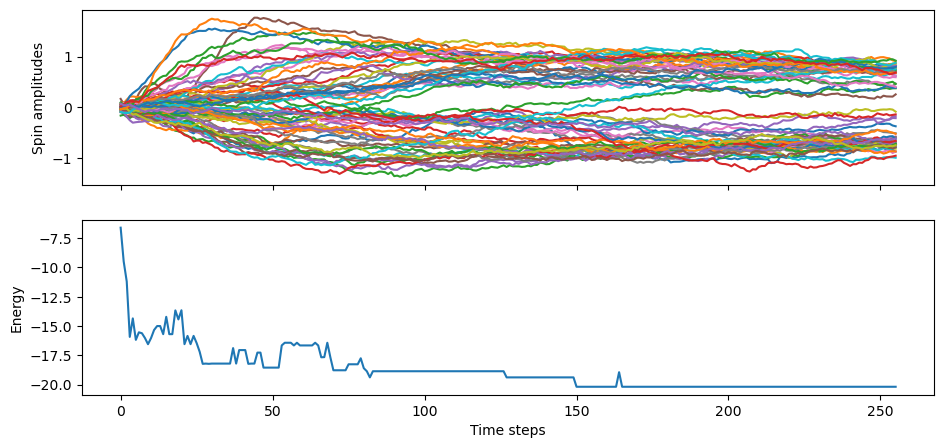

In [27]:
# num_anneals = 64
num_anneals = 20

N_steps = 256
time_step = 0.01
total_time = N_steps * time_step

r = 0.98
mu = 1
beta = 1
target_a_baseline = 0
gamma = 1/(N_steps * time_step)
coupling_str = 100

use_sign = 1
use_last = 0
add_noise = 1

for snr in snr_list:
    path_to_instances  = path_to_all_instances  + instance_type + str(snr) + "/"
    path_to_solutions  = path_to_all_solutions  + instance_type + str(snr) + "/"
    path_to_solved     = path_to_all_solved     + instance_type + str(snr) + "/"
    path_to_hls_solved = path_to_all_HLS_solved + instance_type + str(snr) + "/"

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_to_instances)
    if not isExist:
      print("No instances for snr = ", snr)
      print("Need to generate instances first")
      break

    # Check whether the specified path exists or not
    isExist_solved = os.path.exists(path_to_solved)
    if not isExist_solved:
      os.makedirs(path_to_solved)
      print("Created new directory for solved snr=", snr)
        
    isExist_hls_solved = os.path.exists(path_to_hls_solved)
    if not isExist_hls_solved:
      os.makedirs(path_to_hls_solved)
      print("Created new directory for HLS solved snr=", snr)

    for k in range(numInstances):
        with open(path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt", "r") as file:
            # print("Reading file ", path_to_instances + "DI_MIMO_J_Quad_" + str(k) + ".txt")
            J = np.loadtxt(file)
        N = len(J)

        data, energies, solution, best_energy = CIM_AHC_tf(total_time, J, time_step=time_step, \
            r=r, mu = 1, beta=beta, target_a_baseline=target_a_baseline, \
                num_anneals=num_anneals, coupling_str=coupling_str, \
                use_sign=use_sign, gamma=gamma, modulate_parameter="target_a", add_noise=add_noise)  # target_a or coupling_str
        # print("Best energy = ", best_energy)
                
        # when solution is all zero, means the algorithm converge
        n = 2*N_t
        # print("solution.shape=", solution.shape)
        # print(solution[0:n]+solution[n:2*n])
        
        with open(path_to_solved +  "DI_MIMO_sol_" + str(k) + ".txt", "w") as file:
          np.savetxt(file, solution, fmt="%s")

fig, ax = plt.subplots(2,1, sharex = True, figsize=(11,5))

for i in range(N):
    ax[0].plot(data[i,:])

print("SNR=", snr_list[-1])
ax[0].set_ylabel("Spin amplitudes")
ax[1].plot(energies)
ax[1].set_ylabel("Energy")
plt.xlabel("Time steps")



## Bit error rate

the plot is good for low snr

In [28]:
## This cell is to calculate the bit error rate once we have a solution
def BER(solution_type:str = "ideal"):
	if solution_type == "HLS":
		print("Need to run HLS code to get HLS solution first")

	T = np.identity(2*N_t)
	T = np.concatenate((T,T), axis=1)

	ber = []
	ber_mmse = []
 
	for snr in snr_list:
		path_to_instances  = path_to_all_instances  + instance_type + str(snr) + "/"
		path_to_solutions  = path_to_all_solutions  + instance_type + str(snr) + "/"
		path_to_solved     = path_to_all_solved     + instance_type + str(snr) + "/"
		path_to_hls_solved = path_to_all_HLS_solved + instance_type + str(snr) + "/"

		# Check whether the specified path exists or not
		isExist = os.path.exists(path_to_instances)
		if not isExist:
			print("No instances for snr = ", snr)
			break
		
		isExist = os.path.exists(path_to_solved)
		if not isExist:
			print("No solved solutions for snr = ", snr)
			break

		bitErrors = 0
		bitErrors_mmse = 0

		#For Ising Solution s corresponding decoded symbol in
		for k in range(numInstances):
			path_to_solution = path_to_solutions + "DI_MIMO_mmse_sol_" + str(k) + ".txt"
			with open(path_to_solution, "r") as file:
				x_mmse = np.loadtxt(file, dtype=np.complex128) # ideal solution
				
    	# set solved file path based on solution_type
			if solution_type == "ideal":
				solved_file_name = path_to_solved + "DI_MIMO_sol_" + str(k) + ".txt"
			elif solution_type == "HLS":
				solved_file_name = path_to_hls_solved + "DI_MIMO_sol_" + str(k) + ".txt"
			else:
				print("Invalid solution_type")
				return
  
			# check if the file opened successfully
			if not os.path.exists(solved_file_name):
				print("solved_file not exist: ", solved_file_name)
				break
  
			# with open(path_to_solved + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
			with open(solved_file_name) as file:
				s_quad = np.loadtxt(file) # solution from AHC
				# check if the file is opened successfully
				if s_quad.shape[0] != 65:
					print("s_quad.shape[0] != 2*N_t: ", s_quad.shape[0])
					break

			s = s_quad[0:-1] * s_quad[-1]

			d = T@s
			x_mmse_r = np.concatenate((x_mmse.real,x_mmse.imag),axis=0)
			u = d + x_mmse_r

			u = u[0:N_t] + 1j*u[N_t:]

			b1 = _qam.demodulate(u,demod_type='hard')
			
			b_mmse = _qam.demodulate(x_mmse,demod_type='hard')

			with open(path_to_solutions + "DI_MIMO_sol_" + str(k) + ".txt", "r") as file:
				x = np.loadtxt(file, dtype=np.complex128)

			b2 = _qam.demodulate(x,demod_type='hard')

			bitErrors = bitErrors + sum(abs(b1-b2))
			bitErrors_mmse = bitErrors_mmse + sum(abs(b_mmse-b2))
		
		ber.append(bitErrors/(totalBits*numInstances))
		ber_mmse.append(bitErrors_mmse/(totalBits*numInstances))

	print("snr_list", snr_list)
	print("ber_mmse", ber_mmse)
	print("ber", ber)

	plt.semilogy(snr_list, ber_mmse, "+-")
	plt.semilogy(snr_list, ber, "o-")
	plt.legend(["MMSE", "DI-MIMO"])
	plt.grid(True, which="both")
	plt.xlabel("SNR (dB)")
	plt.ylabel("BER")

snr_list [0, 5, 10, 15, 20, 25, 30]
ber_mmse [0.10796875, 0.04546875, 0.0125, 0.0084375, 0.00359375, 0.00171875, 0.0]
ber [0.07484375, 0.0278125, 0.00375, 0.006875, 0.00125, 0.00109375, 0.0]


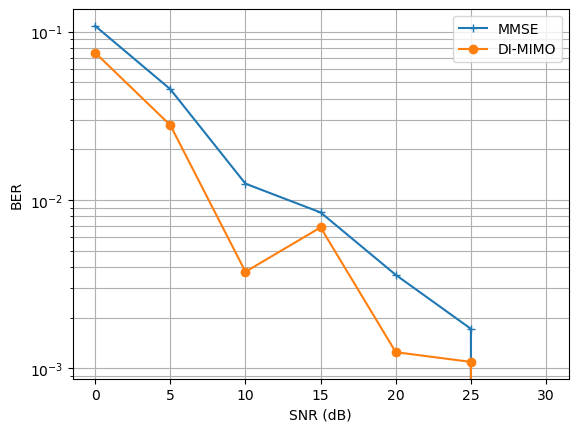

In [29]:
BER("ideal")

Need to run HLS code to get HLS solution first
snr_list [0, 5, 10, 15, 20, 25, 30]
ber_mmse [0.0890625, 0.0578125, 0.0046875, 0.003125, 0.0, 0.0, 0.0]
ber [0.0375, 0.040625, 0.003125, 0.00625, 0.0, 0.0109375, 0.0]


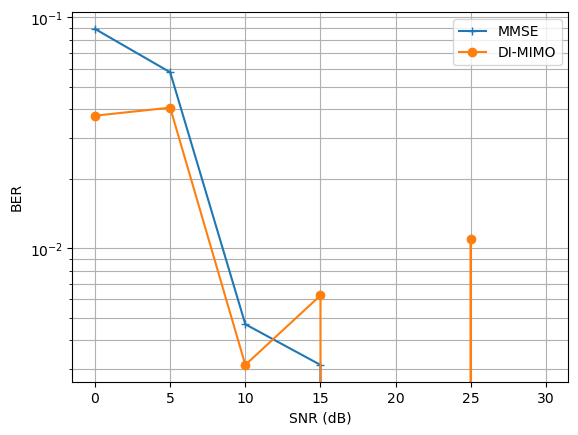

In [23]:
BER("HLS")

# Create Fixed-point Instances

load the generated instance, convert to fixed point and save to file for FPGA testing

*Change `snr` to generate the instance for different snr*



In [10]:
# choose the instance with selected SNR
# snr = snr_list[-1]
snr = 100 # change this for different SNR
print("snr: ", snr)

# define the fixed pt logic format
MAX_WIDTH = 27
intBits = 6
frac_bits = MAX_WIDTH - intBits
# 16.2 = 18
# snr_list = [1,5,10,15,20,25,30] ## in dB // not used
# numInstances = 10    # Number of Ising Instances to generate

# Model parameters
# N_t x N_r MIMO
N_t = 16             # Number Of Transmit antennas
N_r = 16             # Number of Receive antennas
modulation = 16      # Type of modulation

# path to the generated floating pt instances
instance_type = f"Nt{N_t}_Nr{N_r}_{modulation}QAM/" # e.g. "Nt16_Nr16_16QAM_"
path_to_instances = path_to_all_instances + instance_type + str(snr) + "/" # e.g. tb_data\instances\Nt16_Nr16_16QAM\5\

# path to the generated fixed point instances
path_to_pt_fixed_data = path_to_all_HLS_tb + f"fixed_pt_data/{snr}/"  # e.g. tb_data\HLS_tb_data\fixed_pt_data\
# create a new directory if it does not exist
isExist = os.path.exists(path_to_pt_fixed_data)
if not isExist:
    os.makedirs(path_to_pt_fixed_data)
    print("Created new directory for fixed point data")
    
instance_fixed = f"DI_MIMO_J_Conv_11_29_{MAX_WIDTH}_{intBits}" # e.g. "DI_MIMO_J_Conv_11_29_20_2_" + str(snr) + ".txt"

# system parameters
bits_per_symbol = int(math.log2(modulation))
bitsPerEntry = int(0.5*bits_per_symbol)
maxQI = 2*np.sqrt(modulation/4) - 1
_qam = comm.QAMModem(modulation)
totalBits = bits_per_symbol*N_t

H = np.zeros((N_r,N_t),dtype=np.complex128)

# ## Seed for verification
# np.random.seed(1)

# generate fixed point data x_init for the instance
#TODO: modify this to be consistent
file = open(path_to_all_HLS_tb+"init_spins.txt", "w")
for _ in range(20):
    # generate 20 random initial spins as the init_spins.txt
    init_spins = 0.001 * np.random.rand(N) - 0.0005
    x = np.sqrt(0.001) * np.random.normal(0,1,(N, num_anneals))
    fixed_pt_x = [[] for _ in range(1)]
    for j in init_spins:
        val = (int)(j*(2**frac_bits))
        # Handle negative values
        if val < 0:
            val = (val + (1 << (intBits+frac_bits))) % (1 << (intBits+frac_bits))
        hex_val = hex(val)
        fixed_pt_x.append(hex_val)
    for row in fixed_pt_x:
        file.write(' '.join(row) + '\n')
file.close()
print("x_init Writing to file: ", path_to_all_HLS_tb+"init_spins.txt")

# Create a fixed-point array for each J_matrix instance
for k in range(numInstances):
    # read floating pt instance from folder, e.g. tb_data\instances\Nt16_Nr16_16QAM\5\
    file = open(path_to_instances + f"DI_MIMO_J_Quad_{k}.txt", "r")
    J = np.loadtxt(file)
    print(f"J Reading from file: {path_to_instances}DI_MIMO_J_Quad_{k}.txt")
    file.close()
    N = len(J)
    # print(J)

    # empty 2D array
    J_quad_fixed = [[] for _ in range(len(J))]
    
    # for each item in J, convert to fixed point
    for i in range(len(J)):
        for j in J[i]:
            val = (int)(j*(2**frac_bits))
            # Handle negative values
            if val < 0:
                val = (val + (1 << (intBits+frac_bits))) % (1 << (intBits+frac_bits))
            hex_val = hex(val)

            #3res = int(hex_val,16) # convert hex to float
            #if(i==1):
            #   print((res))
            
        #  hex_val = hex_val.zfill(4)

            J_quad_fixed[i].append(hex_val)
    #print(J_quad)
    #print(J_quad_fixed)
    #print(J_quad_fixed_back)

    # write fixed point array to file
    file = open(path_to_pt_fixed_data + f"{instance_fixed}_{k}.txt", "w")
    print(f"J Writing to file: {path_to_pt_fixed_data}{instance_fixed}_{k}.txt")
    for row in J_quad_fixed:
        file.write(' '.join(row) + '\n')
    file.close()
    
print("Done")

snr:  100
Created new directory for fixed point data
x_init Writing to file:  ./tb_data/HLS_tb_data/init_spins.txt


FileNotFoundError: [Errno 2] No such file or directory: './tb_data/instances/Nt16_Nr16_16QAM/100/DI_MIMO_J_Quad_0.txt'

# Verify the HLS solution

In [ ]:
# 